# Are there any true expert review?

Author:
* Luis Henrique M O Imagiire

Status: 
* DONE


Lets use GB data on users' #reviews to see if it has any meaningful impact on ratings.

We believe that there are two groups of reviewers - amateurs and experts - and experts will have a more parsimonious take on the store.

If we find that is the case, we will devise a weighted rating to account for "amateur" reviews.

We will model in a bayesian setting trying to estimate a switch point in the #reviews - where we can use to separate user into one group or another.

In [1]:
%cd ..

/home/luis/ds4a/notebooks


In [2]:
from EDA.util import agg_jsonls  # helper function
from pprint import pprint

def load_unique_GB(dataset_folder):
    unique_ids = set()
    reviewsGB = []
    for complaint in agg_jsonls(dataset_folder):
        if "id_review" in complaint and complaint["id_review"] not in unique_ids:
            unique_ids.add(complaint["id_review"])
            reviewsGB.append(complaint)
    return reviewsGB

reviewsGB = load_unique_GB("final_dataset_GB_1704")
print(f"We have a total of {len(reviewsGB)} reviews!")
pprint(reviewsGB[0])

We have a total of 140416 reviews!
{'caption': '',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0tRQnA3NmhQUzlCWkoyTkE',
 'n_photo_user': 0,
 'n_review_user': 1,
 'rating': 4.0,
 'relative_date': '3 semanas atrás',
 'retrieval_date': '2020-04-15T05:32:36Z',
 'store': 'magazine-luiza',
 'url_user': 'https://www.google.com/maps/contrib/114096832037584768938?hl=pt-BR',
 'username': 'Tiago Leonel Barreto'}


In [5]:
first_k = 10000
n_reviews = [r["n_review_user"] for r in reviewsGB][0:first_k]
rating = [r["rating"] for r in reviewsGB][0:first_k]
max_review_count = max(n_reviews)

In [6]:
import pymc3 as pm
# import theano.tensor as tt



with pm.Model() as model:
    mu0 = pm.Uniform("mug1",0,5)
    sig0 = pm.HalfNormal("sigg1",0.5)
    g1 = pm.Normal("g1", mu0, sig0)
    
    mu1 = pm.Uniform("mug2",0,5)
    sig1 = pm.HalfNormal("sigg2",0.5)
    g2 = pm.Normal("g2", mu1, sig1)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=max_review_count-1)
    
    idx = n_reviews
    mu_t = pm.math.switch(tau > idx, g1, g2)
    sig_t = pm.HalfNormal("sigobs",0.5)
    observation = pm.Normal("obs", mu_t, sig_t, observed=rating)



WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '31161' (I am process '32101')


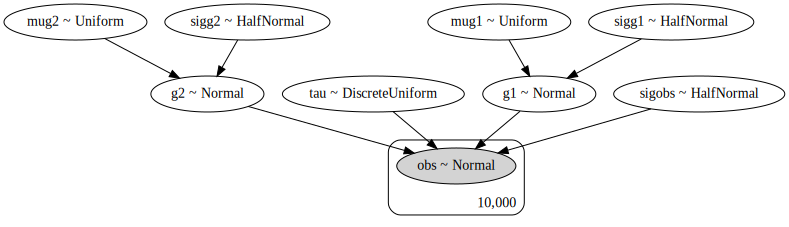

In [7]:
pm.model_graph.model_to_graphviz(model=model)

In [8]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, tune=1000,step=step, cores=6)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigobs]
>Metropolis: [tau]
>Metropolis: [g2]
>Metropolis: [sigg2]
>Metropolis: [mug2]
>Metropolis: [g1]
>Metropolis: [sigg1]
>Metropolis: [mug1]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:09<00:00, 2464.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


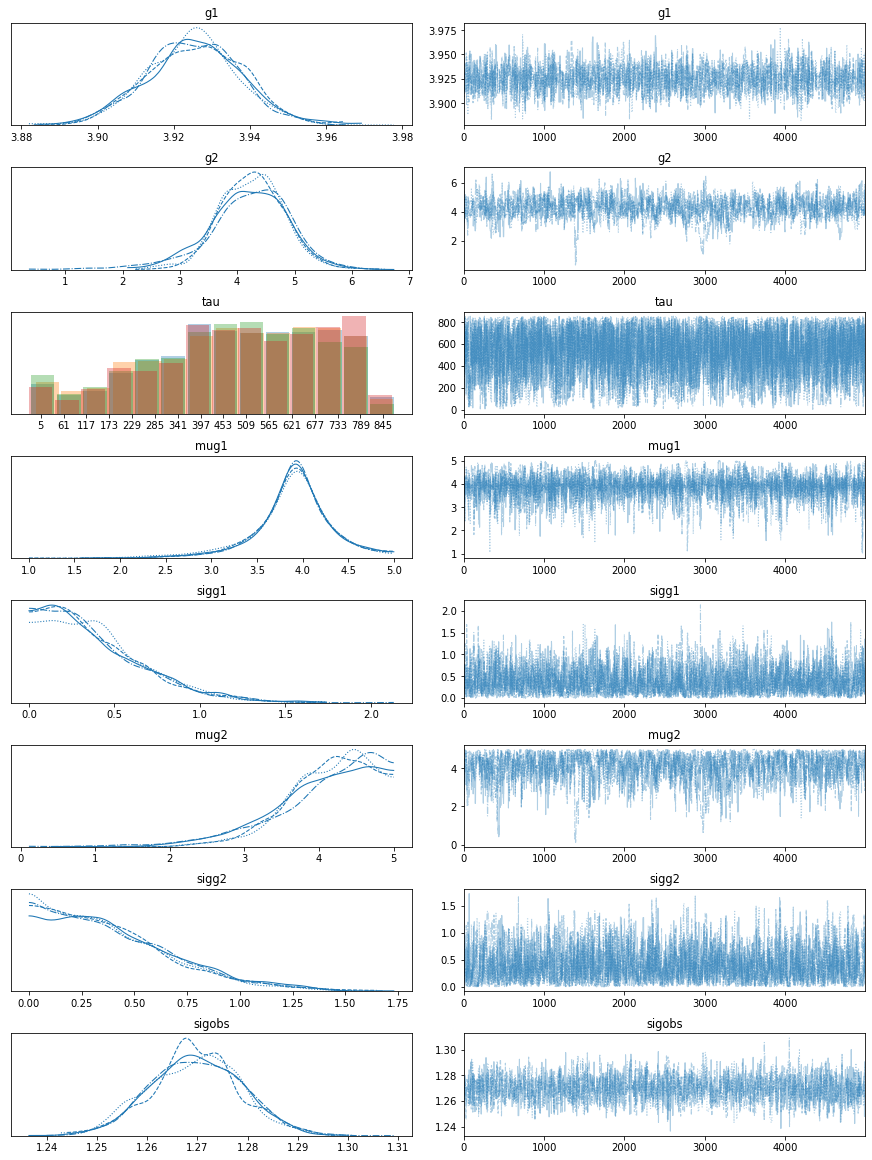

In [9]:

pm.traceplot(trace);

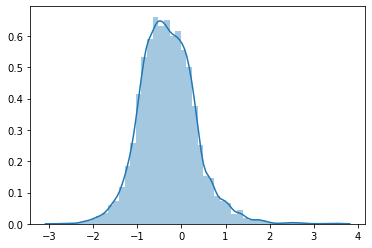

In [20]:
import seaborn as sns

sns.distplot()

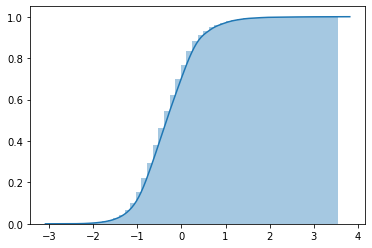

In [21]:
kwargs = {'cumulative': True}
sns.distplot(trace["g1"] - trace["g2"], hist_kws=kwargs, kde_kws=kwargs)

In [17]:
import pandas as pd

pd.Series([r["rating"] for r in reviewsGB if r["n_review_user"] > 5]).describe()


count    20912.000000
mean         3.976808
std          1.290440
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
dtype: float64

In [16]:

pd.Series([r["rating"] for r in reviewsGB if r["n_review_user"] < 5]).describe()

count    116415.000000
mean          3.908981
std           1.267784
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
dtype: float64

## Remarks

Really hard to argue for any meaningful difference between groups looking at #reviews only. Therefore, we are not pursuing this matter further.